In [25]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [26]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [27]:
#https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000

In [28]:
# Get crime data
crimes = requests.get(
    "https://data.cityofnewyork.us/api/views/5jvd-shfj/rows.json?accessType=DOWNLOAD"
).json()

KeyboardInterrupt: 

In [ ]:
requests.get(
    "https://data.cityofnewyork.us/api/views/5jvd-shfj/rows.json?accessType=DOWNLOAD" 
    ).json() 

{'meta': {'view': {'id': '5jvd-shfj',
   'name': 'Crime Map!',
   'assetType': 'map',
   'attribution': 'Police Department (NYPD)',
   'averageRating': 0,
   'category': 'Public Safety',
   'createdAt': 1491354378,
   'description': 'This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) for all complete quarters so far this year (2016). For additional details, please see the attached data dictionary in the ‘About’ section.',
   'displayType': 'map',
   'downloadCount': 1863,
   'hideFromCatalog': True,
   'hideFromDataJson': True,
   'locked': False,
   'newBackend': True,
   'numberOfComments': 0,
   'oid': 38565872,
   'provenance': 'community',
   'publicationAppendEnabled': False,
   'publicationDate': 1501708020,
   'publicationGroup': 13877134,
   'publicationStage': 'published',
   'rowsUpdatedAt': 1721670446,
   'rowsUpdatedBy': 'd5dp-fses',
   'tableId': 18735282,
   'totalTimesRated': 0,
   'viewCount'

In [ ]:
crimes.columns

AttributeError: 'dict' object has no attribute 'columns'

In [ ]:
# This code converts a list of restaurant data into a GeoDataFrame with geographic coordinates.  

crimes = gpd.GeoDataFrame(
    crimes,
    geometry=gpd.points_from_xy(
        [float(x["Longitude"]) for x in crimes],
        [float(x["Latitude"]) for x in crimes],
    ),
)

TypeError: string indices must be integers, not 'str'

In [29]:
crimes.head

AttributeError: 'dict' object has no attribute 'head'

In [30]:
crimes.drop_duplicates(subset="camis", inplace=True)

AttributeError: 'dict' object has no attribute 'drop_duplicates'

In [31]:
crimes.grade.value_counts()

AttributeError: 'dict' object has no attribute 'grade'

C:\Users\jiang\AppData\Local\Temp\ipykernel_24032\3252032623.py:5: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(north, south, east, west, network_type="walk")


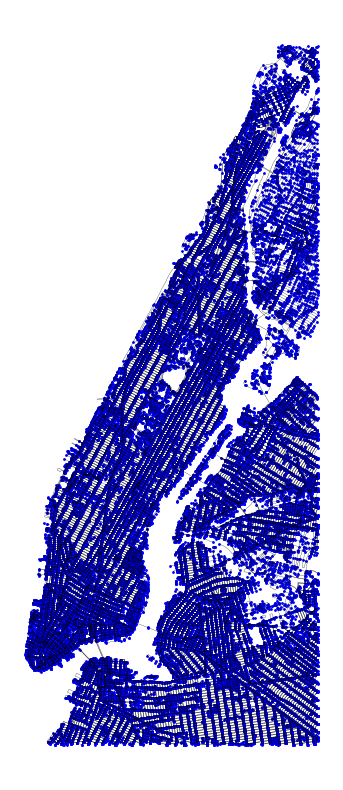

In [ ]:
# Setting the boundaries of Manhattan
north, south, east, west = 40.882214, 40.679548, -73.907000, -74.047285

# Access to Manhattan's pedestrian network
mh_network = ox.graph_from_bbox(north, south, east, west, network_type="walk")

mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

ax = mh_net_edges.plot(
    color="black", 
    linewidth=0.1, 
    figsize=(10, 10)
)
mh_net_nodes.plot(ax=ax, color="blue", markersize=1).set_axis_off()


In [ ]:
my_apartment = Point(-73.958919, 40.809089)  
orig = ox.distance.nearest_nodes(mh_network, my_apartment.x, my_apartment.y)


In [ ]:
def distance_from_point(row, origin):
    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

parks["distance_from_my_apartment"] = parks.apply(
    distance_from_point, origin=orig, axis=1
)

parks = pd.concat(
    [
        parks.drop(["distance_from_my_apartment"], axis=1),
        parks["distance_from_my_apartment"].apply(pd.Series),
    ],
    axis=1,
)

parks_routes = gpd.GeoDataFrame(parks, geometry="route_geom", crs="EPSG:4326")

# Mapping
ax = gpd.GeoSeries(my_apartment).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
parks_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
parks.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()

for x, y, label in zip(parks.geometry.x, parks.geometry.y, parks.park_name):
    ax.text(x, y, label, fontsize=6)
ax.text(my_apartment.x, my_apartment.y, "My Apartment", fontsize=6)

plt.title("Distance from My Apartment to Manhattan Parks")


ValueError: Unknown column route_geom